In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, LongType
import pyspark.sql.functions as F
import keras
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
topic = "MSFT"
server = 'localhost:9092'
scala_version = '2.12'
spark_version = '3.5.0'
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:3.6.1'
]

In [4]:
def create_spark_session():
    try:
        spark_session = (SparkSession.builder.appName("Reddit_comments_analysis")
                         .master("local").config("spark.jars.packages", ",".join(packages))
                         .getOrCreate())
        spark_session.sparkContext.setLogLevel("ERROR")
        print('Spark session created successfully')
        return spark_session
    except Exception:
        print("Couldn't create the spark session")
    


In [5]:
def create_initial_dataframe(spark):
    try:
        init_df = (spark.readStream.format("kafka")
                   .option("kafka.bootstrap.servers", server)
                   .option("subscribe", topic)
                   .option("startingOffsets", "latest")
                   .load())
        print("Initial dataframe created successfully")
        return init_df
    except Exception as e:
        print(f"Initial dataframe couldn't be created due to exception: {e}")
    

In [6]:
def create_final_dataframe(df):
    schema = StructType([StructField('date', StringType(), True),
                         StructField('open', StringType(), True),
                         StructField('high', StringType(), True),
                         StructField('low', StringType(), True),
                         StructField('close', StringType(), True),
                         StructField('adj_close', StringType(), True),
                         StructField('volume', StringType(), True),
                         ])
    df = df.selectExpr("CAST(value AS STRING)")
    df = df.withColumn("value", F.from_json("value", schema)).select("value.*")
    
    return df

In [7]:
def start_streaming(df):
    print("Streaming is being started...")
    query = df \
        .writeStream \
        .trigger(processingTime='3 seconds') \
        .outputMode("append") \
        .format("memory") \
        .queryName('new') \
        .start()
    return query.awaitTermination(1)

In [8]:
from IPython.core.display_functions import clear_output
from time import sleep

def write_streaming_data():
    spark = create_spark_session()
    df = create_initial_dataframe(spark)
    df_final = create_final_dataframe(df)
    start_streaming(df_final)
    return spark

In [9]:
spark =  write_streaming_data()

Spark session created successfully
Initial dataframe created successfully
Streaming is being started...


In [1]:

# Download historical data for SPY from Yahoo Finance
df = pd.read_csv('MSFT.csv', index_col='Date')
display(df.dtypes)
training_data = df['Close'][:'2019-12-31']
validation_data = df['Close']['2020-01-01':'2020-12-31']
# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'pd' is not defined

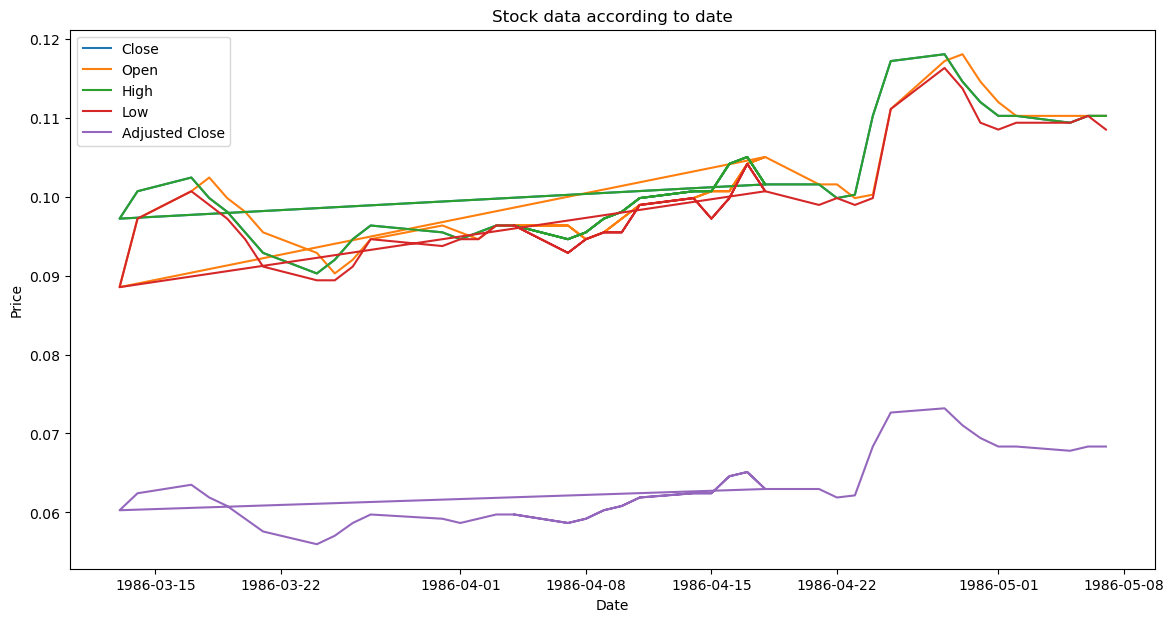

KeyboardInterrupt: 

In [10]:

columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM new')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')
    plt.figure(figsize=(14,7))
    plt.plot(result['date'].tail(50), result['close'].tail(50), label='Close')
    plt.plot(result['date'].tail(50), result['open'].tail(50), label='Open')
    plt.plot(result['date'].tail(50), result['high'].tail(50), label='High')
    plt.plot(result['date'].tail(50), result['low'].tail(50), label='Low')
    plt.plot(result['date'].tail(50), result['adj_close'].tail(50), label='Adjusted Close')
    plt.legend()
    # Update the x and y limits
    plt.draw()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock data according to date')
    # Redra
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)

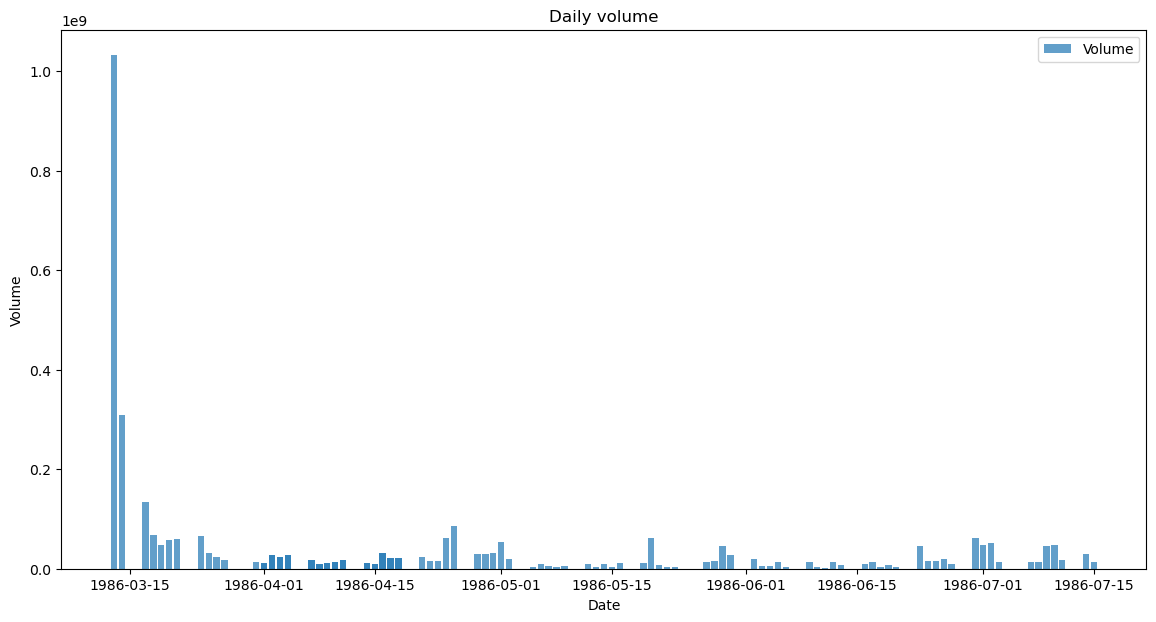

KeyboardInterrupt: 

In [11]:


columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM MSFT')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')
    plt.figure(figsize=(14,7))
    plt.bar(result['date'].tail(100), result['volume'].tail(100), label='Volume', alpha=0.7)
    plt.legend()
    # Update the x and y limits
    plt.draw()
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title('Daily volume')
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)

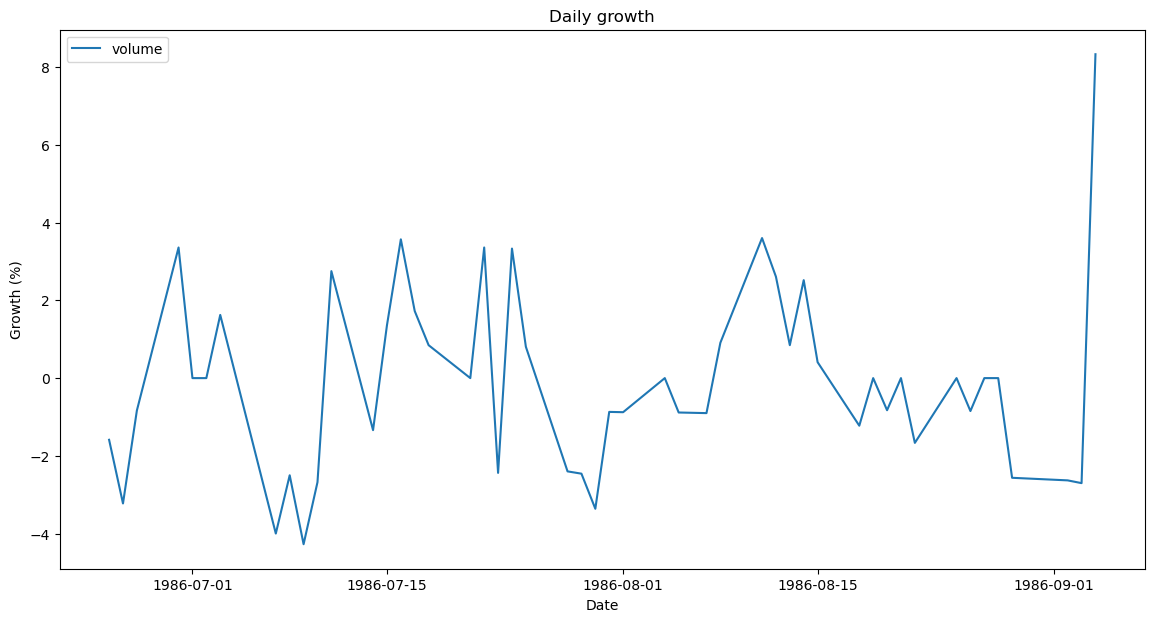

KeyboardInterrupt: 

In [12]:

columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM MSFT')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')

    result['growth'] = result['close'].pct_change() * 100
    plt.figure(figsize=(14,7))
    plt.plot(result['date'].tail(50), result['growth'].tail(50), label=column)
    plt.legend()
    # Update the x and y limits
    plt.draw()
    plt.xlabel('Date')
    plt.ylabel('Growth (%)')
    plt.title('Daily growth')
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)

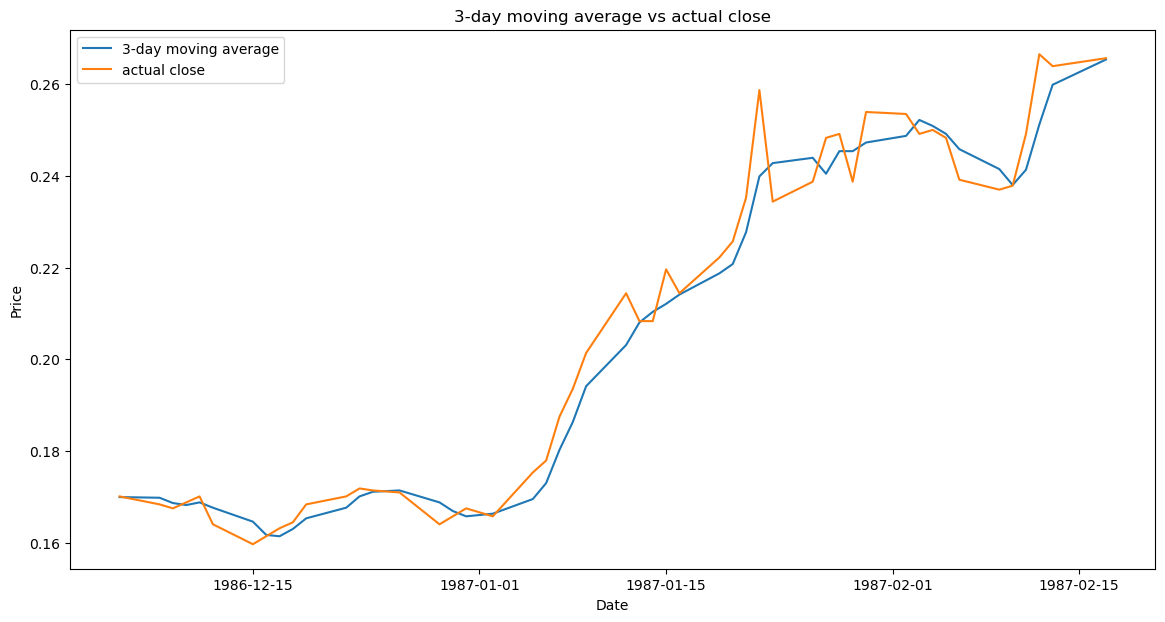

KeyboardInterrupt: 

In [15]:

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import pandas as pd

columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM MSFT')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')

    result['3_day_mavg'] = result['close'].rolling(3).mean()
    mae = mean_absolute_error(result['close'].dropna()[2:], result['3_day_mavg'].dropna())
    mse = mean_squared_error(result['close'].dropna()[2:], result['3_day_mavg'].dropna())
    rmse = sqrt(mse)
    plt.figure(figsize=(14,7))
    plt.plot(result['date'].tail(50), result['3_day_mavg'].tail(50), label='3-day moving average')
    plt.plot(result['date'].tail(50), result['close'].tail(50), label='actual close')
    error_text = f'RMSE: {rmse:.4f}\nMSE: {mse:.4f}\nMAE: {mae:.4f}'

# Add text box in the plot
    plt.legend()
    # Update the x and y limits
    plt.draw()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('3-day moving average vs actual close')
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)

Exception ignored in: <function JavaObject.__init__.<locals>.<lambda> at 0x0000027FF5B70C20>
Traceback (most recent call last):
  File "C:\Spark\python\lib\py4j-0.10.9.7-src.zip\py4j\java_gateway.py", line 1360, in <lambda>
  File "C:\Spark\python\lib\py4j-0.10.9.7-src.zip\py4j\java_gateway.py", line 643, in _garbage_collect_object
KeyboardInterrupt: 


KeyboardInterrupt: 

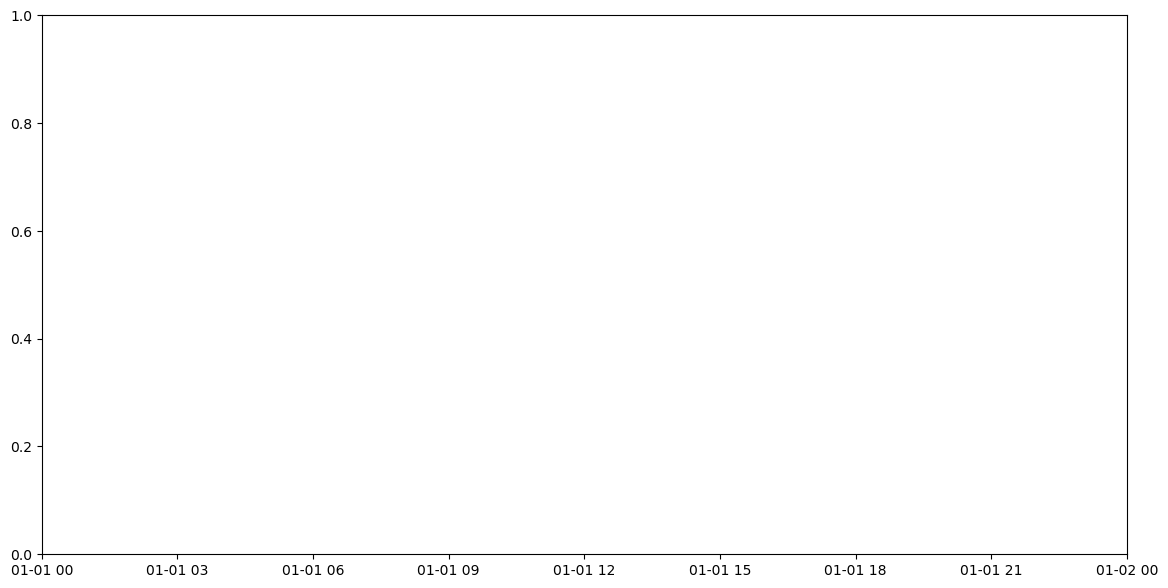

In [16]:


columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM MSFT')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')

    result['6_day_mavg'] = result['close'].rolling(6).mean()
    mae = mean_absolute_error(result['close'].dropna()[5:], result['6_day_mavg'].dropna())
    mse = mean_squared_error(result['close'].dropna()[5:], result['6_day_mavg'].dropna())
    rmse = sqrt(mse)
    plt.figure(figsize=(14,7))
    plt.plot(result['date'].tail(50), result['6_day_mavg'].tail(50), label='6-day moving average')
    plt.plot(result['date'].tail(50), result['close'].tail(50), label='actual close')
    error_text = f'RMSE: {rmse:.4f}\nMSE: {mse:.4f}\nMAE: {mae:.4f}'

    # Add text box in the plot
    
    plt.legend()
    # Update the x and y limits
    plt.draw()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('6-day moving average vs actual close')
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)

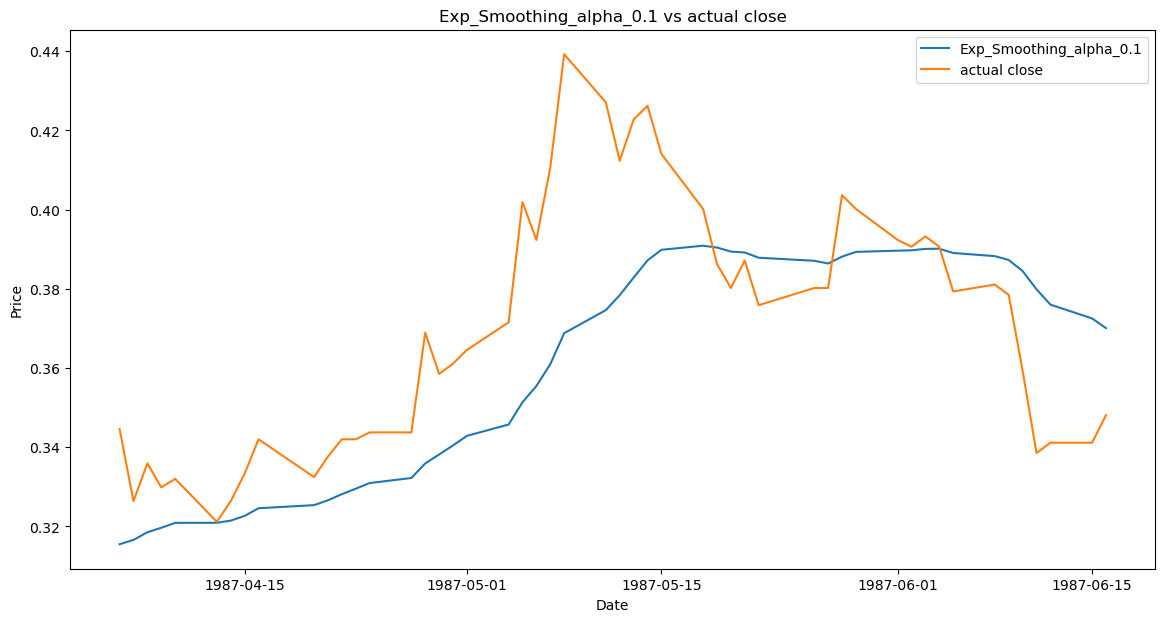

KeyboardInterrupt: 

In [18]:


columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM MSFT')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')

    result['Exp_Smoothing_alpha_0.1'] = result['close'].ewm(alpha=0.1).mean()
    mae = mean_absolute_error(result['close'].dropna(), result['Exp_Smoothing_alpha_0.1'].dropna())
    mse = mean_squared_error(result['close'].dropna(), result['Exp_Smoothing_alpha_0.1'].dropna())
    rmse = sqrt(mse)
    plt.figure(figsize=(14,7))
    plt.plot(result['date'].tail(50), result['Exp_Smoothing_alpha_0.1'].tail(50), label='Exp_Smoothing_alpha_0.1')
    plt.plot(result['date'].tail(50), result['close'].tail(50), label='actual close')
    error_text = f'RMSE: {rmse:.4f}\nMSE: {mse:.4f}\nMAE: {mae:.4f}'

    # Add text box in the plot
    
    plt.legend()
    # Update the x and y limits
    plt.draw()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Exp_Smoothing_alpha_0.1 vs actual close')
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)

In [19]:

columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Create an empty figure and line plot

plt.ion()  # Turn on interactive mode

for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM MSFT')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')

    fitted_model = ExponentialSmoothing(result['close'], trend ='add', seasonal='add', seasonal_periods = 60).fit()
    test_predictions = fitted_model.forecast(30)
    test_predictions.index = np.arange(max(result.index), max(result.index)+len(test_predictions))
    result['close'].plot(legend=True, label='close', figsize=(12, 6))
    test_predictions.plot(legend=True,label='PREDICTIONS')
    plt.plot(test_predictions.index, test_predictions, label='Predictions', linestyle='--', color='red')
    plt.title('Train, Test and Predicted data points using Holt Winters Exponential Smoothing')
    plt.pause(0.01)
    sleep(3)
    clear_output(wait=True)


KeyboardInterrupt



48/48 [==============================] - 1s 18ms/step


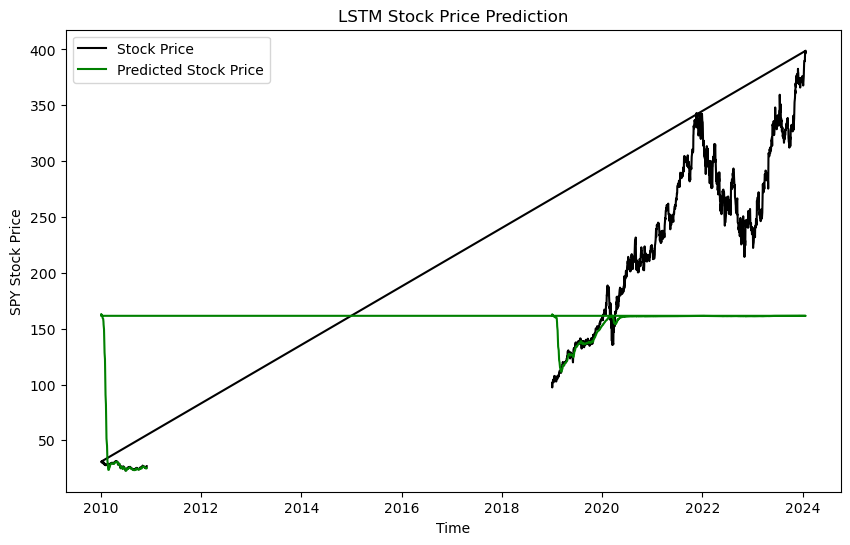

In [ ]:
columns_to_convert = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

plt.ion()
for _ in range(10000):
    spark_df = spark.sql('SELECT * FROM new')
    result = spark_df.toPandas()
    result['date'] = pd.to_datetime(result['date'])
    for column in columns_to_convert:
        result[column] = pd.to_numeric(result[column], errors='coerce')
    
    real_stock_price = result['close'].values.reshape(-1, 1)
    dataset_total = pd.concat((df['Close'], result['close']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(result) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(60, len(inputs)):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    
    plt.figure(figsize=(10, 6))
    plt.plot(result['date'], real_stock_price, color='black', label='Stock Price')
    plt.plot(result['date'], predicted_stock_price, color='green', label='Predicted Stock Price')
    
    plt.title('LSTM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('SPY Stock Price')
    plt.legend()
    plt.show()
    plt.pause(0.01)
    sleep(10)
    clear_output(wait=True)